In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
from sklearn.model_selection import train_test_split

# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier

# Import Bagging Classifier.
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# import data
data = pd.read_csv('./Data/oc_daily.csv')

In [3]:
data.shape

(3653, 7)

In [4]:
data.columns

Index(['date', 'text', 'day_of_week', 'is_holiday', 'Open', 'Close', 'Volume'], dtype='object')

In [5]:
# drop text column 
data.drop(columns='text',inplace=True)


In [6]:
# check if date is datetime object 
type(data.loc[0,'date'])

str

In [7]:
# check format of date 
data['date'][0]

'2011-07-29'

In [8]:
# convert str to date time 
datetime.datetime.strptime('2011-07-29','%Y-%m-%d').date()

datetime.date(2011, 7, 29)

In [9]:
# convert all dates to datetime objects 
data['date']= data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').date() )

In [10]:
# confirm results
type(data.loc[0,'date'])

datetime.date

In [11]:
# make date index 
data.set_index('date',inplace=True)

In [12]:
#confirm results
data.index

Index([2011-07-29, 2011-07-30, 2011-07-31, 2011-08-01, 2011-08-02, 2011-08-03,
       2011-08-04, 2011-08-05, 2011-08-06, 2011-08-07,
       ...
       2021-08-08, 2021-08-09, 2021-08-10, 2021-08-11, 2021-08-12, 2021-08-13,
       2021-08-14, 2021-08-15, 2021-08-16, 2021-08-17],
      dtype='object', name='date', length=3653)

In [13]:
# look at data types and check for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3653 entries, 2011-07-29 to 2021-08-17
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day_of_week  3653 non-null   int64  
 1   is_holiday   3653 non-null   int64  
 2   Open         3653 non-null   float64
 3   Close        3653 non-null   float64
 4   Volume       3653 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 171.2+ KB


- No nulls 

- day_of_week and is_holiday should be dummified 


In [14]:
# dummify day_of_week and is_holiday
data= pd.get_dummies(data,columns=['day_of_week','is_holiday'],drop_first=True)

In [15]:
# check results
data.columns

Index(['Open', 'Close', 'Volume', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'is_holiday_1'],
      dtype='object')

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3651 entries, 2011-07-31 to 2021-08-17
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week_1   3651 non-null   uint8  
 1   day_of_week_2   3651 non-null   uint8  
 2   day_of_week_3   3651 non-null   uint8  
 3   day_of_week_4   3651 non-null   uint8  
 4   day_of_week_5   3651 non-null   uint8  
 5   day_of_week_6   3651 non-null   uint8  
 6   is_holiday_1    3651 non-null   uint8  
 7   Open_pct        3651 non-null   float64
 8   Close_pct       3651 non-null   float64
 9   Volume_diff     3651 non-null   float64
 10  Open_pct_l1     3651 non-null   float64
 11  Close_pct_l1    3651 non-null   float64
 12  Volume_diff_l1  3651 non-null   float64
 13  direction       3651 non-null   object 
dtypes: float64(6), object(1), uint8(7)
memory usage: 382.2+ KB


In [16]:
# look at open,close, and volume columns 
data[['Open','Close','Volume']].head()

,Open,Close,Volume
date,,,
2011-07-29,1300.119995,1292.280029,5.061190e+09
2011-07-30,1292.280029,1292.280029,0.000000e+00
2011-07-31,1292.280029,1292.280029,0.000000e+00
2011-08-01,1292.589966,1286.939941,4.967390e+09
2011-08-02,1286.560059,1254.050049,5.206290e+09


- Change from actual value to change to percent change from the day before 

In [17]:
# change from values to percent change from previous day 
data['Open_pct']= data['Open'].pct_change()
data['Close_pct']= data['Close'].pct_change()
data['Volume_diff']= data['Volume'].diff()

In [18]:
# check results 
data[['Open_pct','Close_pct','Volume_diff']]

,Open_pct,Close_pct,Volume_diff
date,,,
2011-07-29,NaN,NaN,NaN
2011-07-30,-0.006030,0.000000,-5.061190e+09
2011-07-31,0.000000,0.000000,0.000000e+00
2011-08-01,0.000240,-0.004132,4.967390e+09
2011-08-02,-0.004665,-0.025557,2.389000e+08
...,...,...,...
2021-08-13,0.004219,0.001607,-1.722300e+08
2021-08-14,0.000708,0.000000,-2.371630e+09
2021-08-15,0.000000,0.000000,0.000000e+00


In [19]:
# check how many nulls introduced 
data.isnull().sum()

Open             0
Close            0
Volume           0
day_of_week_1    0
day_of_week_2    0
day_of_week_3    0
day_of_week_4    0
day_of_week_5    0
day_of_week_6    0
is_holiday_1     0
Open_pct         1
Close_pct        1
Volume_diff      1
dtype: int64

In [20]:
# drop first row 
data= data[1:]

In [21]:
# confirm results
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3652 entries, 2011-07-30 to 2021-08-17
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           3652 non-null   float64
 1   Close          3652 non-null   float64
 2   Volume         3652 non-null   float64
 3   day_of_week_1  3652 non-null   uint8  
 4   day_of_week_2  3652 non-null   uint8  
 5   day_of_week_3  3652 non-null   uint8  
 6   day_of_week_4  3652 non-null   uint8  
 7   day_of_week_5  3652 non-null   uint8  
 8   day_of_week_6  3652 non-null   uint8  
 9   is_holiday_1   3652 non-null   uint8  
 10  Open_pct       3652 non-null   float64
 11  Close_pct      3652 non-null   float64
 12  Volume_diff    3652 non-null   float64
dtypes: float64(6), uint8(7)
memory usage: 224.7+ KB


- Remove Open, Close, and Volume 

In [22]:
data.drop(columns=['Open','Close','Volume'],inplace=True)

In [23]:
# confirm results
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3652 entries, 2011-07-30 to 2021-08-17
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day_of_week_1  3652 non-null   uint8  
 1   day_of_week_2  3652 non-null   uint8  
 2   day_of_week_3  3652 non-null   uint8  
 3   day_of_week_4  3652 non-null   uint8  
 4   day_of_week_5  3652 non-null   uint8  
 5   day_of_week_6  3652 non-null   uint8  
 6   is_holiday_1   3652 non-null   uint8  
 7   Open_pct       3652 non-null   float64
 8   Close_pct      3652 non-null   float64
 9   Volume_diff    3652 non-null   float64
dtypes: float64(3), uint8(7)
memory usage: 139.1+ KB


- Trying to predict Open_pct 

- Cannot use open_pct, Close_pct, and Volume_diff for the day being predicted because those will not be known in advance as we trying to predict how the market will change from closing the day before. 

- We will know the price from yesterday so we can add a lag for that. 

In [24]:
# add columns for previous days price info 
data['Open_pct_l1']=data['Open_pct'].shift(1)
data['Close_pct_l1']=data['Close_pct'].shift(1)
data['Volume_diff_l1']=data['Volume_diff'].shift(1)

In [25]:
# drop first row since added lag 
data= data[1:]

In [26]:
# make sure no nulls left 
data.isnull().sum()

day_of_week_1     0
day_of_week_2     0
day_of_week_3     0
day_of_week_4     0
day_of_week_5     0
day_of_week_6     0
is_holiday_1      0
Open_pct          0
Close_pct         0
Volume_diff       0
Open_pct_l1       0
Close_pct_l1      0
Volume_diff_l1    0
dtype: int64

For classification add column for price going up,down, or same 

In [27]:
def get_direction(value):
    if value>0: return 'up'
    elif value<0: return 'down'
    else: return 'same'

In [28]:
data['direction']=data['Open_pct'].apply(get_direction)

In [29]:
data['direction'].value_counts(normalize=True)

up      0.470830
down    0.363462
same    0.165708
Name: direction, dtype: float64

Market has been going up so makes sense

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3651 entries, 2011-07-31 to 2021-08-17
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week_1   3651 non-null   uint8  
 1   day_of_week_2   3651 non-null   uint8  
 2   day_of_week_3   3651 non-null   uint8  
 3   day_of_week_4   3651 non-null   uint8  
 4   day_of_week_5   3651 non-null   uint8  
 5   day_of_week_6   3651 non-null   uint8  
 6   is_holiday_1    3651 non-null   uint8  
 7   Open_pct        3651 non-null   float64
 8   Close_pct       3651 non-null   float64
 9   Volume_diff     3651 non-null   float64
 10  Open_pct_l1     3651 non-null   float64
 11  Close_pct_l1    3651 non-null   float64
 12  Volume_diff_l1  3651 non-null   float64
 13  direction       3651 non-null   object 
dtypes: float64(6), object(1), uint8(7)
memory usage: 253.1+ KB


# Classification models 

In [31]:
# define X and y 
X= data.drop(columns=['Open_pct','Close_pct','Volume_diff','direction'])
y=data['direction']

In [32]:
# train test split 
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,
                                               shuffle=False)

## Logistic Regression 

In [35]:
logreg = LogisticRegression(penalty='none',random_state=42,)

# fit model 
logreg.fit(X_train,y_train)

LogisticRegression(penalty='none', random_state=42)

In [36]:
# get accuracy scores 
accuracy_score(y_train,logreg.predict(X_train))

0.43938356164383563

In [37]:
accuracy_score(y_test,logreg.predict(X_test))

0.43912448700410395

In [36]:
# for use with get_acc function 
# defines train/test split X and y for getting accuracy
vars_list1 = [X_train,X_test,y_train,y_test]

In [35]:
# helper function to get accuracy for model
def get_acc(model,vars_list):
    'given fitted model and [X_train,X_test,y_train,y_test] returns test and train accuracy'
    print(f'Train Accuracy: {accuracy_score(vars_list[2],model.predict(vars_list[0]))}')
    print(f'Test Accuracy: {accuracy_score(vars_list[3],model.predict(vars_list[1]))}')
    return

In [40]:
get_acc(logreg,vars_list1)

Train Accuracy: 0.43938356164383563
Test Accuracy: 0.43912448700410395


## KNN  

In [40]:
# scale data for KNN model 
ss= StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# make vars list for metrics later 
vars_list_ss = [Xs_train,Xs_test,y_train,y_test]

In [45]:
# define params for gridsearch 
knn_params= {
    'n_neighbors':[3,5,7,9],
    'weights':['uniform','distance'],
    'p':[1,2]
}


In [46]:
# instantiate knn_gs 
knn_gs = GridSearchCV(KNeighborsClassifier(n_jobs=-1),knn_params,n_jobs=-1,cv=3,verbose=2)

In [47]:
# fit knn_gs
knn_gs.fit(Xs_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [48]:
knn_gs.best_params_

{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

In [49]:
pd.DataFrame(knn_gs.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'param_p', 'param_weights', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [50]:
pd.DataFrame(knn_gs.cv_results_)[['param_n_neighbors', 'param_p', 'param_weights','mean_test_score']]

,param_n_neighbors,param_p,param_weights,mean_test_score
0,3,1,uniform,0.801021
1,3,1,distance,0.797254
2,3,2,uniform,0.796226
3,3,2,distance,0.793145
4,5,1,uniform,0.803073
5,5,1,distance,0.797592
6,5,2,uniform,0.801018
7,5,2,distance,0.798278
8,7,1,uniform,0.799989
9,7,1,distance,0.796907


In [51]:
get_acc(knn_gs,vars_list_ss)

Train Accuracy: 0.8359589041095891
Test Accuracy: 0.771545827633379


## Decision Tree 

In [53]:
# Instantiate model with random_state = 42.
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(Xs_train,y_train)

DecisionTreeClassifier(random_state=42)

In [54]:
get_acc(dt,vars_list_ss)

Train Accuracy: 0.927054794520548
Test Accuracy: 0.7838577291381669


## Bagging Classifier 

In [56]:
# Instantiate and fit model 
bag = BaggingClassifier(random_state=42).fit(Xs_train,y_train)

In [57]:
# get metrics 
get_acc(bag,vars_list_ss)

Train Accuracy: 0.9171232876712329
Test Accuracy: 0.8071135430916553


## Random Forest 

In [59]:
# instantiate and fit model 
randfor = RandomForestClassifier(random_state=42,).fit(Xs_train,y_train)

In [60]:
# check metrics 
get_acc(randfor,vars_list_ss)

Train Accuracy: 0.927054794520548
Test Accuracy: 0.8071135430916553


## Gradient Boosting 

In [62]:
# instantiate and fit gradient boosting model 
gradboost= GradientBoostingClassifier(random_state=42,).fit(Xs_train,y_train)

In [63]:
get_acc(gradboost,vars_list_ss)

Train Accuracy: 0.861986301369863
Test Accuracy: 0.8002735978112175


## XGBClassifier 

In [65]:
# instantiate and fit model 
xgb_class = XGBClassifier().fit(Xs_train,y_train)

/home/tanveer/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:44:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
get_acc(xgb_class,vars_list_ss)

Train Accuracy: 0.9267123287671233
Test Accuracy: 0.8030095759233926


## SVM 

In [68]:
# instantiate and fit model 
svc = SVC(random_state=42,).fit(Xs_train,y_train)

In [69]:
get_acc(svc,vars_list_ss)

Train Accuracy: 0.8383561643835616
Test Accuracy: 0.79890560875513


## Feed Forward Neural Network 


In [47]:
# helper function to plot train and val accuracy 
def plot_acc(hist):
    plt.plot(hist.history['acc'], label='Train accuracy')
    plt.plot(hist.history['val_acc'], label='Test accuracy')
    plt.legend();

In [49]:
# check how many columns in X_train 
X_train.shape

(2920, 10)

In [49]:
# helper function 
def num_direction(value):
    if value=='up': return 1
    elif value=='down': return -1
    else: return 0


In [50]:
y_train.value_counts()

up      1345
down    1080
same     495
Name: direction, dtype: int64

In [51]:
# test if it works 
y_train.apply(num_direction)

date
2011-07-31    0
2011-08-01    1
2011-08-02   -1
2011-08-03   -1
2011-08-04    1
             ..
2019-08-03   -1
2019-08-04    0
2019-08-05   -1
2019-08-06   -1
2019-08-07   -1
Name: direction, Length: 2920, dtype: int64

In [52]:
# make y categorical for use with neural networks 
y_train_nn = to_categorical(y_train.apply(num_direction),3)
y_test_nn = to_categorical(y_test.apply(num_direction),3)

In [53]:
# for metrics later 
vars_nn = [Xs_train,Xs_test,y_train_nn,y_test_nn]

In [72]:
# model network 
fnn = Sequential()
fnn.add(Dense(128,activation="relu", input_shape=(10,)))
fnn.add(Dense(64, activation="relu"))
fnn.add(Dense(3, activation="softmax"))

# compile model 
fnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# check model 
fnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 9,859
Trainable params: 9,859
Non-trainable params: 0
_________________________________________________________________


In [94]:
pd.DataFrame(y_test_nn).isnull().sum()

0    0
1    0
2    0
dtype: int64

In [ ]:
validation_data=(Xs_test,y_test_nn)

In [98]:
#hist_fnn = fnn.fit(Xs_train,y_train_nn,batch_size=72,epochs=100,
#                   validation_data=(Xs_test,y_test_nn),shuffle=False,)

In [ ]:
# check results
#get_acc(fnn,vars_nn)

## RNN 

In [96]:
X.columns

Index(['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'is_holiday_1', 'Open_pct_l1',
       'Close_pct_l1', 'Volume_diff_l1'],
      dtype='object')

In [55]:
# Create training sequences
train_sequences = TimeseriesGenerator(Xs_train, y_train_nn, length=1,batch_size=64)

# Create Test Sequences
test_sequences = TimeseriesGenerator(Xs_test, y_test_nn, length=1,batch_size=64)

In [56]:
train_sequences[0][0].shape


(64, 1, 10)

In [57]:
len(test_sequences[0])


2

In [58]:
input_shape = train_sequences[0][0][0].shape

### rnn

In [117]:
# model network 

rnn = Sequential()
rnn.add(GRU(8,input_shape=input_shape, return_sequences=True))
rnn.add(GRU(8,return_sequences=False)) # false if next layer dense
rnn.add(Dense(10,activation='relu'))
rnn.add(Dense(3))

# compile model 
rnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# show summary 
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 1, 8)              480       
_________________________________________________________________
gru_3 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 1,035
Trainable params: 1,035
Non-trainable params: 0
_________________________________________________________________


In [118]:
hist_rnn = rnn.fit(train_sequences,validation_data=test_sequences,
                  epochs=50,verbose=2)

Epoch 1/50
46/46 - 3s - loss: 5.2436 - acc: 0.3580 - val_loss: 4.5563 - val_acc: 0.3548
Epoch 2/50
46/46 - 0s - loss: 3.5638 - acc: 0.4036 - val_loss: 2.1304 - val_acc: 0.4438
Epoch 3/50
46/46 - 0s - loss: 4.0149 - acc: 0.4519 - val_loss: 6.1126 - val_acc: 0.4740
Epoch 4/50
46/46 - 0s - loss: 6.1977 - acc: 0.4323 - val_loss: 5.9207 - val_acc: 0.4137
Epoch 5/50
46/46 - 0s - loss: 4.8633 - acc: 0.3306 - val_loss: 5.0703 - val_acc: 0.3178
Epoch 6/50
46/46 - 0s - loss: 4.3506 - acc: 0.2919 - val_loss: 4.9912 - val_acc: 0.3260
Epoch 7/50
46/46 - 0s - loss: 3.9890 - acc: 0.2795 - val_loss: 3.2864 - val_acc: 0.1986
Epoch 8/50
46/46 - 0s - loss: 2.0157 - acc: 0.1583 - val_loss: 2.0028 - val_acc: 0.1425
Epoch 9/50
46/46 - 0s - loss: 4.5150 - acc: 0.1572 - val_loss: 5.3003 - val_acc: 0.1740
Epoch 10/50
46/46 - 0s - loss: 4.8976 - acc: 0.2758 - val_loss: 4.5688 - val_acc: 0.3027
Epoch 11/50
46/46 - 0s - loss: 3.7161 - acc: 0.3700 - val_loss: 2.3103 - val_acc: 0.4452
Epoch 12/50
46/46 - 0s - loss:

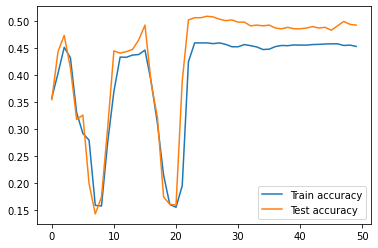

In [126]:
plot_acc(hist_rnn)

### rnn2

In [122]:
# model network 

rnn2 = Sequential()
rnn2.add(GRU(80,input_shape=input_shape, return_sequences=True))
rnn2.add(GRU(80,return_sequences=False)) # false if next layer dense
rnn2.add(Dense(10,activation='relu'))
rnn2.add(Dense(3))

# compile model 
rnn2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# show summary 
rnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 80)             22080     
_________________________________________________________________
gru_7 (GRU)                  (None, 80)                38880     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                810       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 33        
Total params: 61,803
Trainable params: 61,803
Non-trainable params: 0
_________________________________________________________________


In [123]:
hist_rnn2 = rnn2.fit(train_sequences,validation_data=test_sequences,
                  epochs=500,verbose=2)

Epoch 1/500
46/46 - 2s - loss: nan - acc: 0.1723 - val_loss: nan - val_acc: 0.1507
Epoch 2/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 3/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 4/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 5/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 6/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 7/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 8/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 9/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 10/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 11/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
Epoch 12/500
46/46 - 0s - loss: nan - acc: 0.1692 - val_loss: nan - val_acc: 0.1507
E

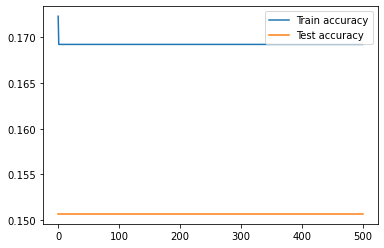

In [125]:
plot_acc(hist_rnn2)

### rnn3 <--rnn

adding another GRU+dense layer to rnn 

In [128]:
# model network 

rnn3 = Sequential()

rnn3.add(GRU(8,input_shape=input_shape, return_sequences=True))
rnn3.add(GRU(8,return_sequences=True))
rnn3.add(GRU(8,return_sequences=False)) # false if next layer dense

rnn3.add(Dense(10,activation='relu'))
rnn3.add(Dense(10,activation='relu'))

rnn3.add(Dense(3))

# compile model 
rnn3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# show summary 
rnn3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 1, 8)              480       
_________________________________________________________________
gru_12 (GRU)                 (None, 1, 8)              432       
_________________________________________________________________
gru_13 (GRU)                 (None, 8)                 432       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 33        
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
____________________________________________________

In [129]:
hist_rnn3 = rnn3.fit(train_sequences,validation_data=test_sequences,
                  epochs=100,verbose=2)

Epoch 1/100
46/46 - 4s - loss: 3.4864 - acc: 0.3700 - val_loss: 1.0008 - val_acc: 0.4466
Epoch 2/100
46/46 - 0s - loss: 0.8566 - acc: 0.4635 - val_loss: 0.9078 - val_acc: 0.5000
Epoch 3/100
46/46 - 0s - loss: 2.7757 - acc: 0.5224 - val_loss: 6.7503 - val_acc: 0.5315
Epoch 4/100
46/46 - 0s - loss: 10.6622 - acc: 0.4806 - val_loss: 8.6849 - val_acc: 0.5110
Epoch 5/100
46/46 - 0s - loss: 7.7356 - acc: 0.4608 - val_loss: 8.4323 - val_acc: 0.5110
Epoch 6/100
46/46 - 0s - loss: 7.5684 - acc: 0.4608 - val_loss: 8.2641 - val_acc: 0.5110
Epoch 7/100
46/46 - 0s - loss: 7.4348 - acc: 0.4608 - val_loss: 8.2363 - val_acc: 0.5110
Epoch 8/100
46/46 - 0s - loss: 7.4272 - acc: 0.4608 - val_loss: 8.2359 - val_acc: 0.5110
Epoch 9/100
46/46 - 0s - loss: 7.4270 - acc: 0.4608 - val_loss: 8.2357 - val_acc: 0.5110
Epoch 10/100
46/46 - 0s - loss: 7.4269 - acc: 0.4608 - val_loss: 8.2357 - val_acc: 0.5110
Epoch 11/100
46/46 - 0s - loss: 7.4269 - acc: 0.4608 - val_loss: 8.2357 - val_acc: 0.5110
Epoch 12/100
46/46

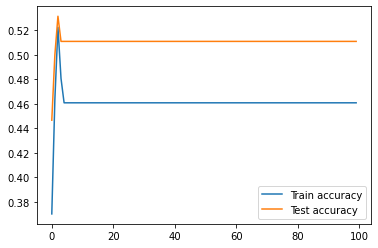

In [130]:
plot_acc(hist_rnn3)

Got higher peak test accuracy and much better overall 



### rnn4 <--rnn3
add another GRU layer + dense layer 

In [134]:
# model network 

rnn4 = Sequential()

rnn4.add(GRU(8,input_shape=input_shape, return_sequences=True))
rnn4.add(GRU(8,return_sequences=True))
rnn4.add(GRU(8,return_sequences=True))
rnn4.add(GRU(8,return_sequences=False)) # false if next layer dense

rnn4.add(Dense(10,activation='relu'))
rnn4.add(Dense(10,activation='relu'))
rnn4.add(Dense(10,activation='relu'))

rnn4.add(Dense(3))

# compile model 
rnn4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# show summary 
rnn4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 1, 8)              480       
_________________________________________________________________
gru_19 (GRU)                 (None, 1, 8)              432       
_________________________________________________________________
gru_20 (GRU)                 (None, 1, 8)              432       
_________________________________________________________________
gru_21 (GRU)                 (None, 8)                 432       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 3)                

In [135]:
hist_rnn4 = rnn4.fit(train_sequences,validation_data=test_sequences,
                  epochs=100,verbose=2)

Epoch 1/100
46/46 - 5s - loss: 3.4717 - acc: 0.3631 - val_loss: 1.0042 - val_acc: 0.5000
Epoch 2/100
46/46 - 0s - loss: 0.9973 - acc: 0.4594 - val_loss: 0.9717 - val_acc: 0.4904
Epoch 3/100
46/46 - 0s - loss: 0.9647 - acc: 0.4498 - val_loss: 0.9597 - val_acc: 0.4548
Epoch 4/100
46/46 - 0s - loss: 0.9359 - acc: 0.4519 - val_loss: 1.1195 - val_acc: 0.5041
Epoch 5/100
46/46 - 0s - loss: 4.6443 - acc: 0.5505 - val_loss: 2.2217 - val_acc: 0.5233
Epoch 6/100
46/46 - 0s - loss: 2.9052 - acc: 0.2011 - val_loss: 2.6953 - val_acc: 0.1507
Epoch 7/100
46/46 - 0s - loss: 2.8608 - acc: 0.1692 - val_loss: 1.8801 - val_acc: 0.1507
Epoch 8/100
46/46 - 0s - loss: 1.5680 - acc: 0.1692 - val_loss: 1.5484 - val_acc: 0.1507
Epoch 9/100
46/46 - 0s - loss: 1.4363 - acc: 0.1692 - val_loss: 1.5470 - val_acc: 0.1507
Epoch 10/100
46/46 - 0s - loss: 1.4194 - acc: 0.1692 - val_loss: 1.5466 - val_acc: 0.1507
Epoch 11/100
46/46 - 0s - loss: 1.4027 - acc: 0.1692 - val_loss: 1.5464 - val_acc: 0.1507
Epoch 12/100
46/46 

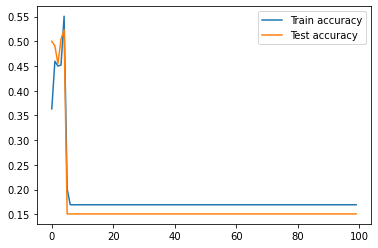

In [136]:
plot_acc(hist_rnn4)

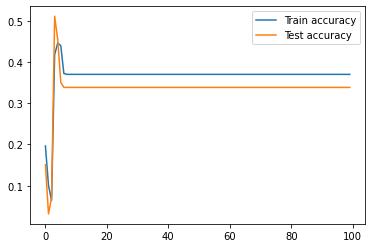

In [133]:
plot_acc(hist_rnn4)

CAN PROBABLY OPTIMIZE THIS MORE WILL COME BACK 

## LTSM 

In [60]:
Xs_train.shape

(2920, 10)

In [61]:
# make df? 
X_train_lstm= np.reshape(Xs_train,(Xs_train.shape[0],1,Xs_train.shape[1]))
X_test_lstm = np.reshape(Xs_test,(Xs_test.shape[0],1,Xs_test.shape[1]))

In [62]:
X_train_lstm.shape

(2920, 1, 10)

In [63]:
X_test_lstm.shape

(731, 1, 10)

In [155]:
# model network 

lstm = Sequential()
lstm.add(LSTM(4,input_shape=(1,10)))
lstm.add(Dense(3))

# compile model 
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [158]:
# fit model 
hist_lstm = lstm.fit(X_train_lstm,y_train_nn,
                     validation_data=(X_test_lstm,y_test_nn),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 0s - loss: 2.4314 - acc: 0.1503 - val_loss: 2.3205 - val_acc: 0.1272
Epoch 2/100
92/92 - 0s - loss: 4.2572 - acc: 0.1503 - val_loss: 4.4810 - val_acc: 0.1272
Epoch 3/100
92/92 - 0s - loss: 4.2096 - acc: 0.1442 - val_loss: 1.3942 - val_acc: 0.1259
Epoch 4/100
92/92 - 0s - loss: 4.3501 - acc: 0.1408 - val_loss: 5.7383 - val_acc: 0.1245
Epoch 5/100
92/92 - 0s - loss: 6.8193 - acc: 0.1510 - val_loss: 6.3551 - val_acc: 0.1354
Epoch 6/100
92/92 - 0s - loss: 5.3367 - acc: 0.1538 - val_loss: 4.8295 - val_acc: 0.1368
Epoch 7/100
92/92 - 0s - loss: 4.9429 - acc: 0.1685 - val_loss: 5.1165 - val_acc: 0.1409
Epoch 8/100
92/92 - 0s - loss: 4.7932 - acc: 0.1668 - val_loss: 4.7858 - val_acc: 0.1354
Epoch 9/100
92/92 - 0s - loss: 4.5668 - acc: 0.1661 - val_loss: 4.4772 - val_acc: 0.1354
Epoch 10/100
92/92 - 0s - loss: 4.5554 - acc: 0.1654 - val_loss: 5.3608 - val_acc: 0.1313
Epoch 11/100
92/92 - 0s - loss: 6.4198 - acc: 0.1726 - val_loss: 3.9042 - val_acc: 0.1368
Epoch 12/100
92/92 

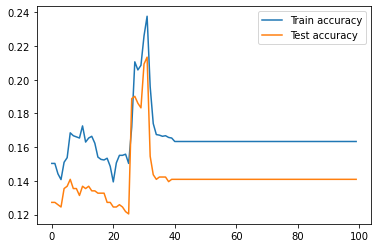

In [159]:
plot_acc(hist_lstm)

- Try more complex model 

In [164]:
# model network 

lstm2 = Sequential()
lstm2.add(LSTM(40,input_shape=(1,10)))
lstm2.add(Dense(30,activation='relu'))
lstm2.add(Dense(3))

# compile model 
lstm2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [165]:
# fit model 
hist_lstm2 = lstm2.fit(X_train_lstm,y_train_nn,
                     validation_data=(X_test_lstm,y_test_nn),
                  epochs=100,verbose=2)

Epoch 1/100
92/92 - 1s - loss: 3.9419 - acc: 0.5836 - val_loss: 1.7162 - val_acc: 0.7346
Epoch 2/100
92/92 - 0s - loss: 3.5619 - acc: 0.7541 - val_loss: 4.5849 - val_acc: 0.6635
Epoch 3/100
92/92 - 0s - loss: 5.7709 - acc: 0.6586 - val_loss: 6.2971 - val_acc: 0.6265
Epoch 4/100
92/92 - 0s - loss: 6.6731 - acc: 0.6442 - val_loss: 6.3516 - val_acc: 0.6265
Epoch 5/100
92/92 - 0s - loss: 6.6901 - acc: 0.6281 - val_loss: 6.2739 - val_acc: 0.6047
Epoch 6/100
92/92 - 0s - loss: 6.9765 - acc: 0.5616 - val_loss: 7.1317 - val_acc: 0.3912
Epoch 7/100
92/92 - 0s - loss: 4.8286 - acc: 0.3812 - val_loss: 4.5292 - val_acc: 0.3529
Epoch 8/100
92/92 - 0s - loss: 4.4897 - acc: 0.3801 - val_loss: 4.6014 - val_acc: 0.3557
Epoch 9/100
92/92 - 0s - loss: 3.7869 - acc: 0.4079 - val_loss: 3.3078 - val_acc: 0.4227
Epoch 10/100
92/92 - 0s - loss: 3.3891 - acc: 0.4178 - val_loss: 3.0352 - val_acc: 0.4268
Epoch 11/100
92/92 - 0s - loss: 3.3566 - acc: 0.4130 - val_loss: 3.0921 - val_acc: 0.4022
Epoch 12/100
92/92 

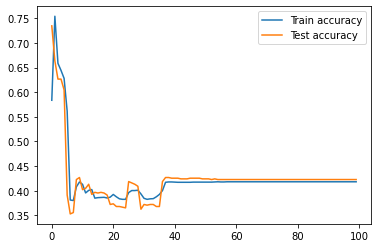

In [166]:
plot_acc(hist_lstm2)

### GridSearch  

In [65]:
# function to make models 
def model_func_lstm(nodes_lstm,nodes_dense):
    model = Sequential()
    model.add(LSTM(nodes_lstm,input_shape=(1,10)))
    model.add(Dense(nodes_dense,activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    return model 

In [66]:
# wrapper 
lstm_modeler = KerasClassifier(build_fn=model_func_lstm,epochs=50)


In [175]:
# params to search over 
params_lstm = {
    'nodes_lstm':[8,16,32,64],
    'nodes_dense':[8,16,32,64]
}

In [176]:
# instantiate grid search 
lstm_gs = GridSearchCV(lstm_modeler,params_lstm,n_jobs=-1,cv=3,verbose=1)

In [177]:
# fit lstm_gs 
lstm_gs.fit(X_train_lstm,y_train_nn)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/100
92/92 [==============================] - 1s 3ms/step - loss: 3.6968 - acc: 0.1993
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 4.0659 - acc: 0.3455
Epoch 3/100
92/92 [==============================] - 0s 3ms/step - loss: 3.7111 - acc: 0.2668
Epoch 4/100
92/92 [==============================] - 0s 3ms/step - loss: 2.4139 - acc: 0.2192
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 4.2672 - acc: 0.2723
Epoch 6/100
92/92 [==============================] - 0s 3ms/step - loss: 4.4208 - acc: 0.4219
Epoch 7/100
92/92 [==============================] - 0s 2ms/step - loss: 4.1577 - acc: 0.5483
Epoch 8/100
92/92 [==============================] - 0s 3ms/step - loss: 4.0432 - acc: 0.4983
Epoch 9/100
92/92 [==============================] - 0s 3ms/step - loss: 3.5102 - acc: 0.3414
Epoch 10/100
92/92 [==============================] - 0s 3ms/step - loss: 3.8342 - acc: 0.341

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa6bc118190>,
             n_jobs=-1,
             param_grid={'nodes_dense': [8, 16, 32, 64],
                         'nodes_lstm': [8, 16, 32, 64]},
             verbose=1)

In [180]:
pd.DataFrame(lstm_gs.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_nodes_dense', 'param_nodes_lstm', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [80]:
def gs_results(gs):
    return pd.DataFrame(lstm_gs.cv_results_)[['params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [187]:
gs_results(lstm_gs)

,params,mean_test_score
9,"{'nodes_dense': 32, 'nodes_lstm': 16}",0.476032
13,"{'nodes_dense': 64, 'nodes_lstm': 16}",0.447291
12,"{'nodes_dense': 64, 'nodes_lstm': 8}",0.410948
15,"{'nodes_dense': 64, 'nodes_lstm': 64}",0.402067
5,"{'nodes_dense': 16, 'nodes_lstm': 16}",0.386633
4,"{'nodes_dense': 16, 'nodes_lstm': 8}",0.384212
3,"{'nodes_dense': 8, 'nodes_lstm': 64}",0.368518
6,"{'nodes_dense': 16, 'nodes_lstm': 32}",0.367444
14,"{'nodes_dense': 64, 'nodes_lstm': 32}",0.361242
11,"{'nodes_dense': 32, 'nodes_lstm': 64}",0.355392


In [188]:
lstm_gs.best_params_

{'nodes_dense': 32, 'nodes_lstm': 16}

In [189]:
lstm_gs.score(X_train_lstm,y_train_nn)

92/92 [==============================] - 0s 1ms/step - loss: 3.9598 - acc: 0.1538


0.15376712381839752

In [191]:
lstm_gs.score(X_test_lstm,y_test_nn)

23/23 [==============================] - 0s 1ms/step - loss: 4.1065 - acc: 0.1395


0.13953489065170288

## BaysianSearch 

https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4

In [68]:
search_space_lstm = {
    'nodes_lstm':Integer(8,100),
    'nodes_dense':Integer(8,100)
}


In [76]:
lstm_bs1 = BayesSearchCV(lstm_modeler,search_space_lstm,n_iter=5,random_state=42,)

In [77]:
# pip install scikit-learn==0.23.2
# https://github.com/scikit-optimize/scikit-optimize/issues/978
# https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796

In [78]:
lstm_bs1.fit(X_train_lstm,y_train_nn)

Epoch 1/100
73/73 [==============================] - 1s 2ms/step - loss: 8.2260 - acc: 0.1918
Epoch 2/100
73/73 [==============================] - 0s 2ms/step - loss: 7.1419 - acc: 0.2530
Epoch 3/100
73/73 [==============================] - 0s 2ms/step - loss: 6.6228 - acc: 0.2920
Epoch 4/100
73/73 [==============================] - 0s 2ms/step - loss: 6.1152 - acc: 0.3532
Epoch 5/100
73/73 [==============================] - 0s 2ms/step - loss: 6.1684 - acc: 0.3827
Epoch 6/100
73/73 [==============================] - 0s 2ms/step - loss: 5.6179 - acc: 0.1943
Epoch 7/100
73/73 [==============================] - 0s 2ms/step - loss: 3.2243 - acc: 0.0210
Epoch 8/100
73/73 [==============================] - 0s 2ms/step - loss: 4.6406 - acc: 0.0081
Epoch 9/100
73/73 [==============================] - 0s 2ms/step - loss: 5.0331 - acc: 0.0672
Epoch 10/100
73/73 [==============================] - 0s 2ms/step - loss: 4.9296 - acc: 0.1460
Epoch 11/100
73/73 [==============================] - 0s 2m

BayesSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4dab7d3790>,
              n_iter=5, random_state=42,
              search_spaces={'nodes_dense': Integer(low=8, high=100, prior='uniform', transform='identity'),
                             'nodes_lstm': Integer(low=8, high=100, prior='uniform', transform='identity')})

In [79]:
lstm_bs1.best_params_

OrderedDict([('nodes_dense', 82), ('nodes_lstm', 48)])

In [89]:
def bs_results(bs):
    return pd.DataFrame(bs.cv_results_)[['params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [90]:
bs_results(lstm_bs1)

,params,mean_test_score
4,"{'nodes_dense': 82, 'nodes_lstm': 48}",0.438356
1,"{'nodes_dense': 85, 'nodes_lstm': 89}",0.438014
3,"{'nodes_dense': 83, 'nodes_lstm': 24}",0.360274
0,"{'nodes_dense': 46, 'nodes_lstm': 75}",0.328767
2,"{'nodes_dense': 49, 'nodes_lstm': 93}",0.282534


### 2nd BS 

make voting classifier model with everything? 
# Regression Models

Outcome: 
Open_pct

Predictors:

day_of_week_1     
day_of_week_2     
day_of_week_3     
day_of_week_4     
day_of_week_5     
day_of_week_6     
is_holiday_1
Open_pct_l1       
Close_pct_l1      
Volume_diff_l1

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3651 entries, 2011-07-31 to 2021-08-17
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week_1   3651 non-null   uint8  
 1   day_of_week_2   3651 non-null   uint8  
 2   day_of_week_3   3651 non-null   uint8  
 3   day_of_week_4   3651 non-null   uint8  
 4   day_of_week_5   3651 non-null   uint8  
 5   day_of_week_6   3651 non-null   uint8  
 6   is_holiday_1    3651 non-null   uint8  
 7   Open_pct        3651 non-null   float64
 8   Close_pct       3651 non-null   float64
 9   Volume_diff     3651 non-null   float64
 10  Open_pct_l1     3651 non-null   float64
 11  Close_pct_l1    3651 non-null   float64
 12  Volume_diff_l1  3651 non-null   float64
 13  direction       3651 non-null   object 
dtypes: float64(6), object(1), uint8(7)
memory usage: 382.2+ KB


In [94]:
data.to_csv('clean_daily_oc.csv')

In [95]:
data.to_pickle('clean_daily_oc.pkl')

In [ ]:
data

# ARIMA 